In [ ]:
!wget https://github.com/d-uni/LPPL_model/archive/refs/heads/main.zip
!unzip main.zip
%cd LPPL_model-main

--2025-12-06 19:14:29--  https://github.com/d-uni/LPPL_model/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/d-uni/LPPL_model/zip/refs/heads/main [following]
--2025-12-06 19:14:29--  https://codeload.github.com/d-uni/LPPL_model/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip.1’

main.zip.1              [ <=>                ] 776.45K  --.-KB/s    in 0.02s   

2025-12-06 19:14:29 (32.8 MB/s) - ‘main.zip.1’ saved [795087]

Archive:  main.zip
9b521ecde95913ab42d507c63218a0cc19e398b6
replace LPPL_model-main/Example_of_usage.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !git clone https://github.com/d-uni/LPPL_model.git
# %cd LPPL_model

In [ ]:
from model_lppls import ModelLPPLS
from rolling_calibrator import RollingLPPLCalibrator
from distribution_calibrators import (
    DistributionLPPLCalibrator_for_different_Windows,
    DistributionLPPLCalibrator_for_different_Dates,
)
from visualization import plot_lppls_results, plot_tc_distribution,plot_combined_tc_distributions

# Test model_lppls.py

In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download("000001.SS", start="2007-01-01", end="2008-01-01")
price_series = data["Close"].dropna()

t1 = "2007-03-12"
t2 = "2007-10-10"
fit_window = price_series[t1:t2]


dates = pd.to_datetime(fit_window.index)
t = (dates - dates[0]).days / 365.25  # time in years since start
p = fit_window.values  # price values

initial_guess = [t[-1] + 0.08, 0.5, 9.0]

model = ModelLPPLS(t, p)
model.set_calibration_date(t2)

model.fit(initial_guess)
model.summary()

[*********************100%***********************]  1 of 1 completed


,calibration_date,tc,A,B,C1,C2,m,omega,kappa,sign
0,2007-10-10,0.573951,1.289635e+08,-1.289634e+08,0.025472,0.037758,2.094974e-10,13.597429,1.289634e+08,1


# Test rolling_calibrator.py

In [32]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2020-01-01", "2025-10-29"
data_rolling_calibrator  = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_rolling_calibrator
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()



rolling_calibrator = RollingLPPLCalibrator(t_series, p_series)

# ------ Acceptance thresholds
rolling_calibrator.set_acceptance_thresholds(
    r2_min=0.95, rmse_max=0.04, kappa_min=0.05, tc_horizon_years=0.5
)

result_rolling_calibrator = rolling_calibrator.run(
    start_roll = 1.0,       # start of rolling period (years)
    end_roll = 4.0,         # end of rolling period (years)
    window_years = 1.0,     # window size
    step_years = 4 / 365.25 # step = 2 days
)

KeyboardInterrupt: 

In [ ]:
result_rolling_calibrator.head()

# Test distribution_calibrators.py

In [ ]:
target_date_ = pd.Timestamp("2010-01-01")

SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2011-01-01"
data_tc_distribution_over_window = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_window
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

calibrator = DistributionLPPLCalibrator_for_different_Windows(t_series, p_series)

# --- Acceptance thresholds ---
calibrator.set_acceptance_thresholds(
    r2_min=0.9,
    rmse_max=0.06,
    kappa_min=0.05,
    tc_horizon_years=0.5
)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)

target_date = (target_date_ - data.index[0]).days / 365.25 #!!!!!!! <- <- <- <- <- <- CONSIDER TARGET DAY

result_tc_distribution_over_window = calibrator.tc_distribution_over_window(
    target_date=target_date,
    min_window_years=1/12,  # 1 month
    max_window_years=1.0,   # 1 year
    step_window_years=1/365.25, # increment by 1 day
    acceptance_thresholds=True # IF you put False -> you don't take into account the thresholds, presented earlier
)

In [18]:
result_tc_distribution_over_window.head()

,window_years,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,0.986824,3.850264,7.005194,-0.425942,0.006988,-0.124646,0.955843,10.337683,0.935262,0.031857,0.425942,1
1,0.989562,3.850185,7.005110,-0.422748,0.009020,-0.126787,0.949539,10.317547,0.933452,0.032235,0.422748,1
2,0.992300,3.850185,7.005110,-0.422748,0.009020,-0.126787,0.949539,10.317547,0.933452,0.032235,0.422748,1
3,0.995038,3.850185,7.005110,-0.422748,0.009020,-0.126787,0.949539,10.317547,0.933452,0.032235,0.422748,1
4,0.997775,3.849825,7.004994,-0.419310,0.011674,-0.128853,0.942006,10.281903,0.931608,0.032615,0.419310,1


In [19]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2011-01-01"
data_tc_distribution_over_dates = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_dates
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

# --- Initialize calibrator ---
calibrator = DistributionLPPLCalibrator_for_different_Dates(t_series, p_series)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
calibrator.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

# --- Parameters ---
target_date = (target_date_ - data.index[0]).days / 365.25
window_years = 1.0                 # fixed calibration window
distribution_window_years = 1/12    # look 6 months before target date
step_years = 1 / 365.25            # 5 days between calibrations

# --- Run distribution over calibration dates ---
result_tc_distribution_over_dates = calibrator.tc_distribution_over_dates(
    target_date=target_date,
    window_years=window_years,
    distribution_window_years=distribution_window_years,
    step_years=step_years,
    acceptance_thresholds=True
)

In [20]:
result_tc_distribution_over_dates.head()

,calibration_date,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,3.935832,3.778750,6.989272,-0.398382,-0.017465,-0.140293,0.806376,8.516232,0.921454,0.033188,0.398382,1
1,3.993326,3.849825,7.004994,-0.419310,0.011674,-0.128853,0.942006,10.281903,0.931608,0.032615,0.419310,1
2,3.996064,3.849825,7.004994,-0.419310,0.011674,-0.128853,0.942006,10.281903,0.931608,0.032615,0.419310,1


# Test visualization.py

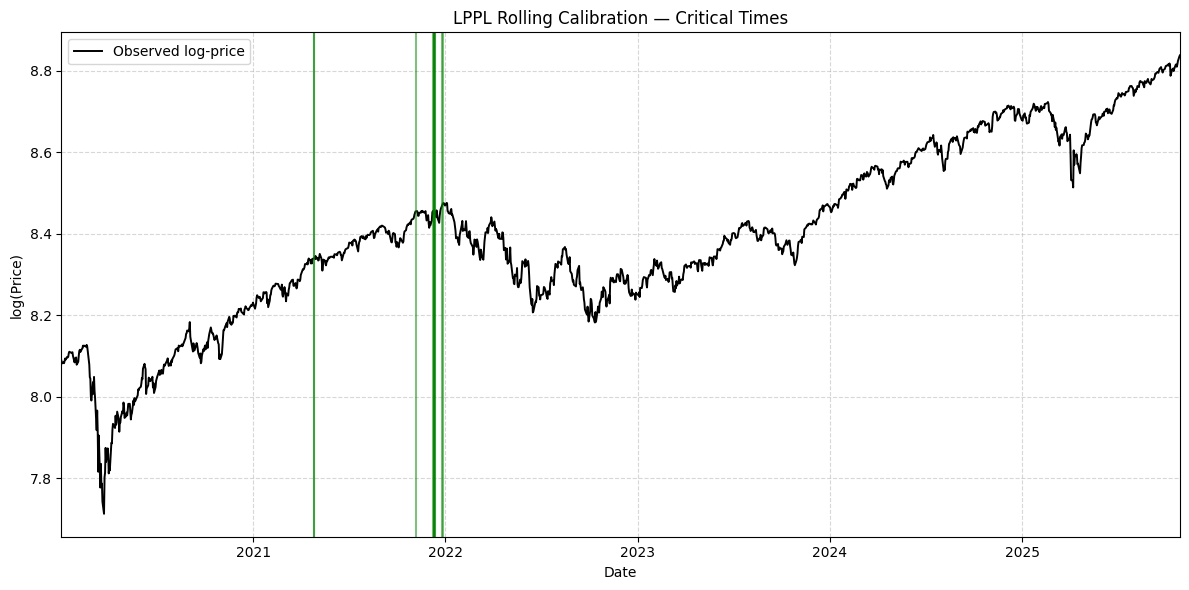

In [21]:
plot_lppls_results(data_rolling_calibrator, result_rolling_calibrator)

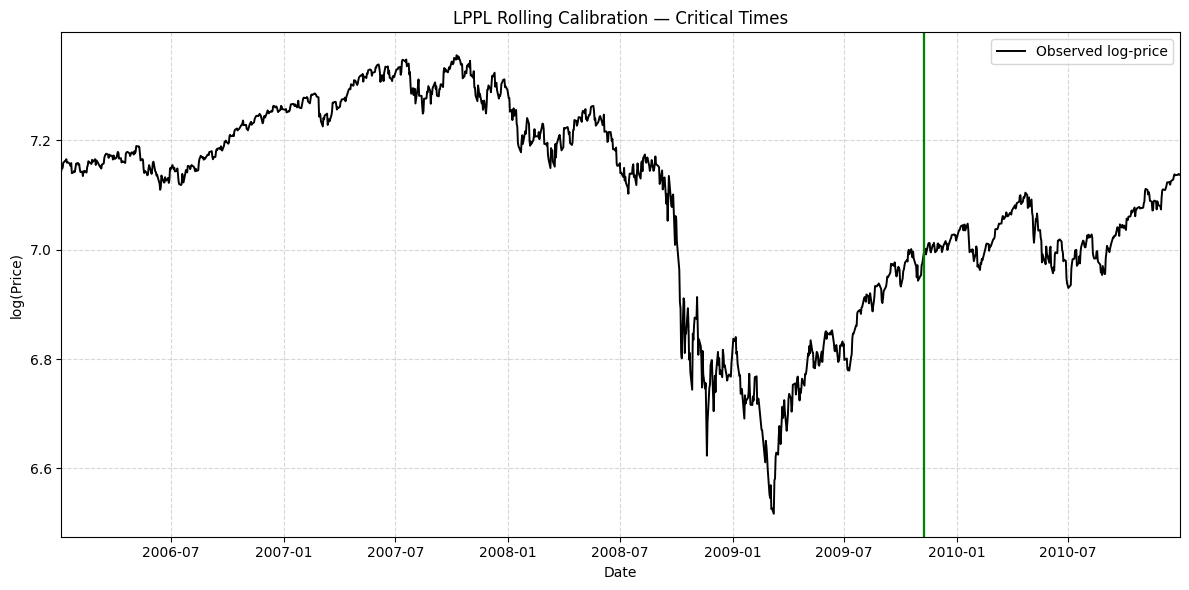

In [22]:
plot_lppls_results(data_tc_distribution_over_window, result_tc_distribution_over_window)

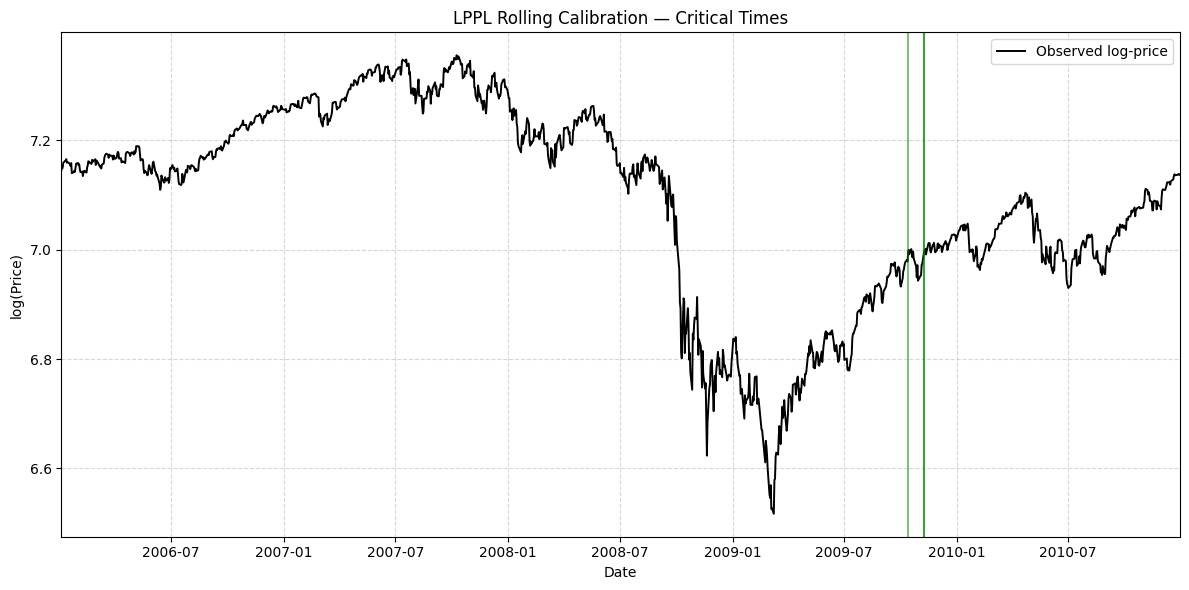

In [23]:
plot_lppls_results(data_tc_distribution_over_dates, result_tc_distribution_over_dates)

In [24]:
tc_predicted_from_start_dates = result_tc_distribution_over_dates["tc"]-(target_date_ - data_tc_distribution_over_dates.index[0]).days / 365.25

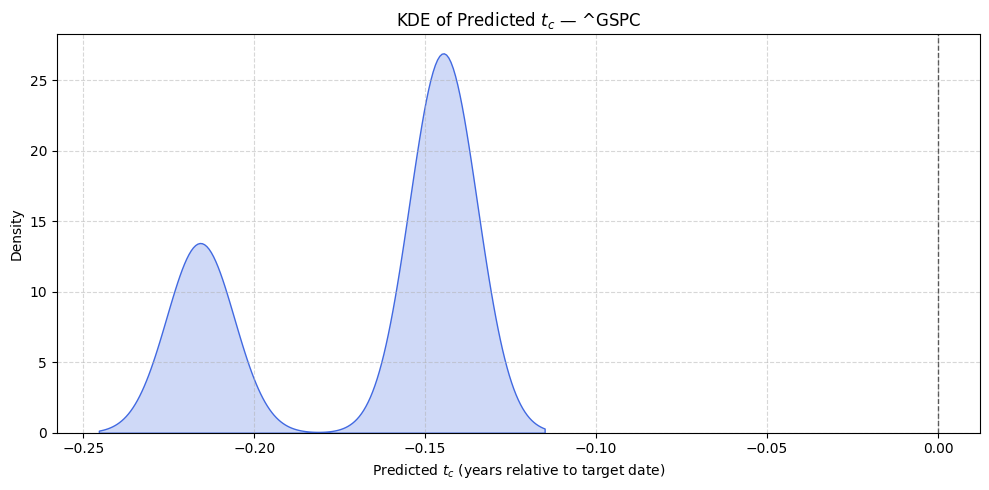

In [25]:
plot_tc_distribution(tc_predicted_from_start_dates, symbol=SYMBOL)

In [26]:
tc_predicted_from_start_window = result_tc_distribution_over_window["tc"]-(target_date_ - data_tc_distribution_over_window.index[0]).days / 365.25

In [27]:
result_tc_distribution_over_window["tc"]

,tc
0,3.850264
1,3.850185
2,3.850185
3,3.850185
4,3.849825
5,3.849825


In [28]:
data_tc_distribution_over_window.index[0]

Timestamp('2006-01-03 00:00:00')

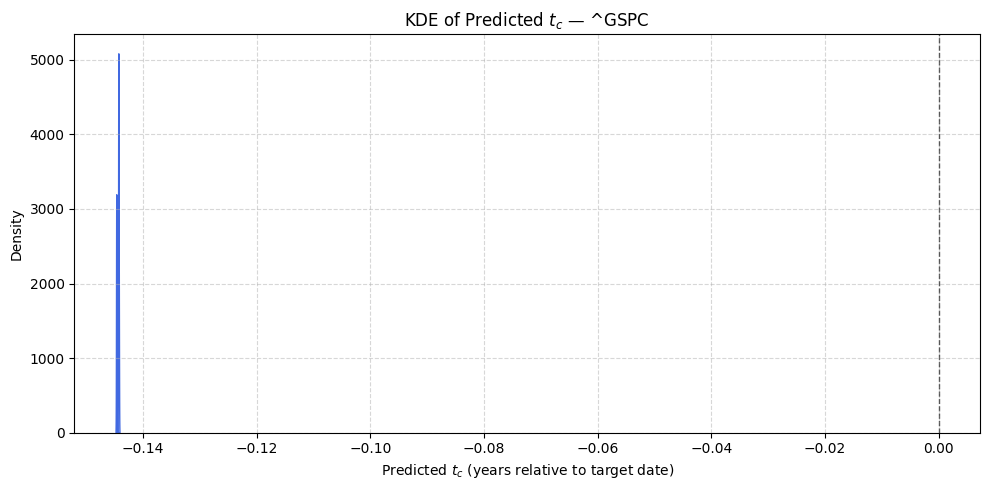

In [29]:
plot_tc_distribution(tc_predicted_from_start_window, symbol=SYMBOL)

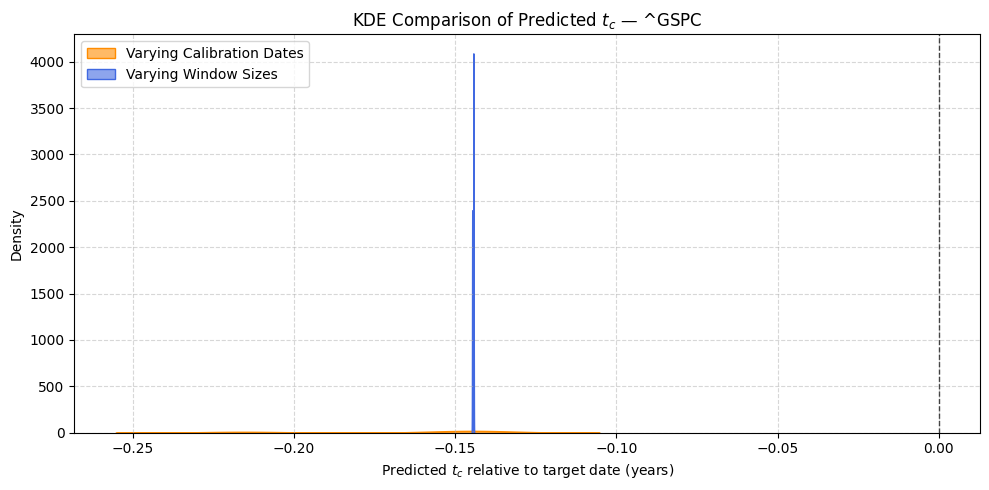

In [30]:
plot_combined_tc_distributions(tc_predicted_from_start_dates, tc_predicted_from_start_window, symbol=SYMBOL)

# Test of LPPLIndicatorGenerator.py

In [ ]:
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1. Download data (example: S&P 500)
SYMBOL = "^GSPC"
data = yf.download(SYMBOL, start="2006-01-01", end="2009-01-01",
                   progress=False, auto_adjust=True)["Close"].dropna()

# 2. Build indicator generator
gen = LPPLIndicatorGenerator(
    price_series=data,
    qualified_fit_r2_min=0.9,
    qualified_fit_rmse_max=0.06,
    qualified_fit_kappa_min=0.05,
    qualified_fit_tc_horizon_years=0.5,
)

# 3. Compute indicator table
indicators = gen.build_indicator_table(
    years_for_calibration=1.5,
    diff_windows_indicator_min_window_years=1/12,
    diff_windows_indicator_max_window_years=1.0,
    diff_windows_indicator_step_window_years=20/365.25,      # coarser for speed
    diff_dates_indicator_neighborhood_years=1/12,
    diff_dates_indicator_step_years_dates=5/365.25,
    crash_HORIZON_years_for_indicator=0.25,
)

# 4. Save to CSV
df = gen.to_csv("lppl_indicators_sp500.csv")
df.head()